# Projeto Parte I

### **1. Imports & Global Variables**

In [126]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
from scipy.linalg import sqrtm, inv
from IPython import display
from sklearn.metrics import mean_squared_error, r2_score

### **2. Main Functions**

In [127]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v, yawrate]]).T
    return u

In [128]:
def observation_input(xd, u):

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Input_Noise[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Input_Noise[1, 1]
    ud = np.array([[ud1, ud2]]).T

    xd = motion_model(xd, ud)

    # noisy input caused by the sensors
    # ud = u + Input_Noise @ np.random.randn(2, 1)
    # xd = motion_model(xd, ud)

    return xd, ud

In [129]:
def observation_filters(xTrue,ekf = True):
    if ekf:
        # add noise to GPS x-y
        zx = xTrue[0, 0] + np.random.randn() * GPS_Noise[0, 0]
        zy = xTrue[1, 0] + np.random.randn() * GPS_Noise[1, 1]
        z = np.array([[zx, zy]])
    else:
        # add noise to gps x-y
        z = observation_model(xTrue) + GPS_Noise @ np.random.randn(2, 1)
    return z
    

- #### Observation (GNSS)
     ![title](Formulas/observation-model.png)

In [130]:
def observation_model(x):
    #  Observation Model
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]])

    z = H.dot(x)

    return z

- #### Dynamic Robot model
     ![title](Formulas/robot-model.png)

In [131]:
def motion_model(x, u):

    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[dt * math.cos(x[2, 0]), 0],
                  [dt * math.sin(x[2, 0]), 0],
                  [0.0, dt],
                  [1.0, 0.0]])

    x = F.dot(x) + B.dot(u)
    return x

### **3. Filters Algorithm Construction**

#### A. Dead Recokning

#### B. Extended Kalman Filter (EKF)
**Parameters**

In [132]:
# Estimation parameters of EKF
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0])**2  # predict state covariance
R = np.diag([1.0, 1.0])**2  # Observation x,y position covariance

#  Simulation parameter
GPS_Noise = np.diag([0.5, 0.5])**2

Input_Noise = np.diag([1.0, np.deg2rad(30.0)])**2

dt = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

show_animation = False

**Jacobian Matrix Calculation**

In [133]:
def jacobH(x):
    # Jacobian of Observation Model
    jH = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]])

    return jH

In [134]:
def jacobF(x, u):
    """
    Jacobian of Motion Model

    motion model
    x_{t+1} = x_t+v*dt*cos(yaw)
    y_{t+1} = y_t+v*dt*sin(yaw)
    yaw_{t+1} = yaw_t+omega*dt
    v_{t+1} = v{t}
    so
    dx/dyaw = -v*dt*sin(yaw)
    dx/dv = dt*cos(yaw)
    dy/dyaw = v*dt*cos(yaw)
    dy/dv = dt*sin(yaw)
    """
    yaw = x[2, 0]
    v = u[0, 0]
    jF = np.array([
        [1.0, 0.0, -dt * v * math.sin(yaw), dt * math.cos(yaw)],
        [0.0, 1.0, dt * v * math.cos(yaw), dt * math.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jF

**EKF Algorithm**

In [135]:
def ekf_estimation(xEst, PEst, z, u):

    #  Predict
    xPred = motion_model(xEst, u)
    jF = jacobF(xPred, u)
    PPred = jF.dot(PEst).dot(jF.T) + Q

    #  Update
    jH = jacobH(xPred)
    zPred = observation_model(xPred)
    y = z.T - zPred
    S = jH.dot(PPred).dot(jH.T) + R
    K = PPred.dot(jH.T).dot(np.linalg.inv(S))
    xEst = xPred + K.dot(y)
    PEst = (np.eye(len(xEst)) - K.dot(jH)).dot(PPred)

    return xEst, PEst

#### C. Undescented Kalman Filter (UKF)
**Parameters**

In [136]:
# Covariance for UKF simulation
Q = np.diag([
    0.1,  # variance of location on x-axis
    0.1,  # variance of location on y-axis
    np.deg2rad(1.0),  # variance of yaw angle
    1.0  # variance of velocity
]) ** 2  # predict state covariance
R = np.diag([1.0, 1.0]) ** 2  # Observation x,y position covariance

#  Simulation parameter
GPS_Noise = np.diag([0.5, 0.5])**2
Input_Noise = np.diag([1.0, np.deg2rad(30.0)])**2

dt = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

#  UKF Parameter
ALPHA = 0.001
BETA = 2
KAPPA = 0


**Weights & Gamma Calculations**
- Lambda Formula

<img src="Formulas/lambda.png" width=350 height=75 />

- Weights Formula

<img src="Formulas/WeightsFormula.png" width=550 height=100 />


In [137]:
def setup_ukf(xDim):
    # calculate lambda
    lamb = ALPHA ** 2 * (xDim + KAPPA) - xDim
    # calculate the weights
    # w^(0)
    wm = [lamb / (lamb + xDim)] # wm corresponds to w of the UKF Algorithm
    # wc^(0)
    wc = [(lamb / (lamb + xDim)) + (1 - ALPHA ** 2 + BETA)]
    for i in range(2 * xDim):
        # w^(+-i)
        wm.append(1.0 / (2 * (xDim + lamb)))
        # wc^(+-i)
        wc.append(1.0 / (2 * (xDim + lamb)))
    
    # define gamma
    gamma = math.sqrt(xDim + lamb)

    wm = np.array([wm])
    wc = np.array([wc])

    return wm, wc, gamma

**UKF Algorithm**
- Sigma Points Genration Formula
<img src="Formulas/GenSigma_Formula.png" width=1000 height=150 />


In [138]:
def generate_sigma_points(xEst, PEst, gamma):
    # Calculate the sigma points using xEst (xhat_k|k), PEst (P_k|k) and gamma
    # or using xPred (xhat_k|k-1), PPred (P_k|k-1) and gamma
    x_0 = xEst

    sigma_neg = xEst - gamma * sqrtm(PEst)
    sigma_pos = xEst + gamma * sqrtm(PEst)

    return np.concatenate((x_0, sigma_neg, sigma_pos), axis=1)

In [139]:
def predict_sigma_motion(sigma, u):
    # Sigma Points prediction with motion model
    return motion_model(sigma, u)

In [140]:
def predict_sigma_observation(sigma):
    # Sigma Points prediction with observation model
    return observation_model(sigma)

- Covarience of sigma Formula
    - Time Update (P_k|k-1)

        <img src="Formulas/Cov_Sigma.png" width=650 height=100 />

    - Measurment Update (P^yy_t|t-1)

        <img src="Formulas/Cov_yy.png" width=700 height=125 />

In [141]:
def calc_sigma_covariance(x, sigma, wc, Pi):
    # Calculate the covariance P = PPred (P_k|k-1) using x = xPred (xhat_k+1|k),
    # sigma (x^(i)_k+1|k), wc and Pi = Q (initial value of PPred)
    # or calculate the covariance P = st (P^yy_t|t-1) using x = zb (yhat_t),
    # sigma = z_sigma (y^(i)_t), wc and Pi = R (initial value of st)
    
    return wc * (sigma-x) @ (sigma-x).T + Pi 

- Covarience(x,y) Formula
<table><tr>
<td> <img src="Formulas/Cov_x_y_Formula_1.png" alt="Drawing" style="width: 600px;"/> </td>
<td> <img src="Formulas/Cov_x_y_Formula_2.png" alt="Drawing" style="width: 600px;"/> </td>
</tr></table>

In [142]:
def calc_pxz(sigma, x, z_sigma, zb, wc):
    # Calculate the covariance Pxz (P^xy_t|t-1) using wc, sigma (x^(i)_t|t-1),
    # x (xhat_t|t-1), z_sigma (y^(i)_t) and zb (yhat_t) and 
    return wc * (sigma-x) @ (z_sigma-zb).T

In [143]:
def ukf_estimation(xEst, PEst, z, u, wm, wc, gamma):
    #  Predict (UKF - time update)
    
    # Calculate the sigma-points 
    # Using: xExt == xhat_k|k and PEst == P_k|k and gamma 
    sigma = generate_sigma_points(xEst, PEst, gamma)

    # Propagate the sigma-points 
    # sigma_propagated = (x^(i)_k+1|k = f(x^(i)_k|k , w^(i)_k)) 
    # using the sigma-points obtained in the previous calculus and u (ud = noisy u)
    sigma_propagated = predict_sigma_motion(sigma, u)

    # xPred == xhat_k+1|k 
    # Using: wm and sigma_propagated
    xPred = wm @ sigma_propagated.T  
    xPred = xPred.T

    # Calculate PPred (P_k|k-1) using xPred, the propagated sigma-points
    # wc and Q in def calc_sigma_covariance
    PPred = calc_sigma_covariance(xPred, sigma_propagated, wc, Q)

    #  Update (UKF - measurement update)
    
    # Calculate zPred (yhat_t) using xPred (xhat_k+1|k) in def observation_model
    zPred = observation_model(xPred)

    # Calculate y = (y_t - yhat_t) using z (y_t) and zPred (yhat_t)
    y = z - zPred

    # Calculate the sigma-points using xPred (xhat_k|k-1), PPred (P_k|k-1)
    # and gamma in def generate_sigma_points
    sigma = generate_sigma_points(xPred, PPred, gamma)

    # Propagate the sigma-points z_sigma (y^(i)_t = h(x^(i)_t|t-1 , e^(i)_t)) 
    # using the propagated sigma-points in def predict_sigma_observation
    z_sigma = predict_sigma_observation(sigma)

    # Calculate zb (yhat_t) using wm and the sigma-points y^(i)_t 
    zb = wm @ z_sigma.T
    zb = zb.T 

    # Calculate the sigma covariance, st (P^yy_t|t-1), using zb (yhat_t),
    # z_sigma (y^(i)_t), wc and R in def calc_sigma_covariance
    st = calc_sigma_covariance(zb, z_sigma, wc, R.T)
    
    # Pxz == (P^xy_t|t-1) 
    # Using sigma (x^(i)_t|t-1), xPred (xhat_t|t-1),
    # z_sigma (y^(i)_t), zb (yhat_t) and wc in def calc_pxz
    Pxz = calc_pxz(sigma, xPred, z_sigma, zb, wc)    
    
    # K_t == Pxz (P^xy_t|t-1)
    K_t = Pxz @ inv(st.astype(float))
    
    # Update xEst (Xhat_t|t) using xPred (xhat_t|t-1), K_t and y (y_t - yhat_t)
    xEst = xPred + K_t @ y
    
    # Update PEst (P_t|t) using PPred (P_t|t-1), K_t and st (P^yy_t|t-1)
    PEst = PPred - K_t @ st @ K_t.T
    
    return xEst, PEst

#### D. Particle Filter 

### **4.Simulation**

#### **A. Functions to measure performance of the algorithms**

In [144]:
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [145]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [146]:
def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [147]:
def get_metrics(xTrue,xPred):
    return np.array([mse(xTrue,xPred),rmse(xTrue,xPred),r2(xTrue,xPred)])

####  **B. Complement Functions**

In [148]:
show_animation = False

def plot_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0
    
    try:
        a = math.sqrt(eigval[bigind])
    except ValueError:
        a = 0

    try:
        b = math.sqrt(eigval[smallind])
    except ValueError:
        b = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

#### **B. Simulation**

In [149]:
ekf = True
ukf = True
pf = False

def simulation():
    
    print("Robot simulation start!")
    xDim = 4  # State Vector [x y yaw v]'

    # xTrue: x_k|k-1 (given by the motion_model using x and u)
    # xDR: xDR_k|k-1 (given by the motion_model using xDR_k-1 and noisy u)
    xTrue = np.zeros((xDim, 1))
    xDR = np.zeros((xDim, 1))  # Dead reckoning    

    xEst_ukf = np.zeros((xDim, 1))
    xEst_ekf = np.zeros((xDim, 1))
    xEst_particle = np.zeros((xDim, 1))

    PEst_ekf = np.eye(xDim)
    PEst_ukf = np.eye(xDim)

    if ukf is True:
        wm, wc, gamma = setup_ukf(xDim)

    # history
    hxTrue = xTrue
    hxDR = xTrue
    hxEst_ekf = xEst_ekf
    hxEst_ukf = xEst_ukf
    hxEst_particle = xEst_particle
    hz = np.zeros((1, 2))
    
    time = 0.0

    fig = plt.figure(figsize = (12,10))
    
    while SIM_TIME >= time:
        time += dt
        # effective values of the input variables (v and omega)
        u = calc_input()
        
        # z: noisy GPS output variables (given by observation_model)
        # ud: noisy u
        xTrue = motion_model(xTrue, u)
        xDR,ud = observation_input(xDR, u)

        if ekf is True:
            z = observation_filters(xTrue)
            xEst_ekf, PEst_ekf = ekf_estimation(xEst_ekf, PEst_ekf, z, ud)
            hxEst_ekf = np.hstack((hxEst_ekf, xEst_ekf))
            hz = np.vstack((hz, z))
        if ukf is True:
            z = observation_filters(xTrue,ekf = False)
            # Estimation of xEst, PEst using the UKF algorithm 
            xEst_ukf, PEst_ukf = ukf_estimation(xEst_ukf, PEst_ukf, z, ud, wm, wc, gamma)
            hxEst_ukf = np.hstack((hxEst_ukf, xEst_ukf))

        if pf is True:
            print("Nada")
        
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
            
        # if show_animation:
        #     plt.cla()
        #     # for stopping simulation with the esc key.
        #     plt.gcf().canvas.mpl_connect('key_release_event',
        #             lambda event: [exit(0) if event.key == 'escape' else None])

        #     plt.plot(hz[0, :], hz[1, :], ".g")
        #     #True Position
        #     plt.plot(hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b")

        #     #Dead Reckoning
        #     plt.plot(hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k")

        #     #EKF
        #     if filters[0] == True:
        #         plt.plot(hxEst_ekf[0, :].flatten(), hxEst_ekf[1, :].flatten(), "-r")
        #         plot_covariance_ellipse(xEst_ekf, PEst_ekf)
        #     #UKF
        #     if filters[1] == True:
        #         plt.plot(hxEst_ukf[0, :].flatten(), hxEst_ekf[1, :].flatten(), "-r")
            
        #     if filters[2] == True:
        #         plt.plot(hxEst_particle[0, :].flatten(), hxEst_particle[1, :].flatten(), "-r")

    
        #     plt.axis("equal")
        #     plt.grid(True)
        #     fig.canvas.draw()
        #     #plt.pause(0.001)
    plt.grid()
    plt.plot(hz[:, 0], hz[:, 1], ".g",label="GPS Signal")
    plt.plot(hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b",label="True Position")
    plt.plot(hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k",label="Dead-Reckoning")
    if ekf is True:
        plt.plot(hxEst_ekf[0, :].flatten(), hxEst_ekf[1, :].flatten(), "-r", label="EKF")
        metricsEKF = get_metrics(hxTrue.T[:, :2], hxEst_ekf.T[:, :2])
    else:
        metricsEKF = None
    
    if ukf is True:
        plt.plot(hxEst_ukf[0, :].flatten(), hxEst_ukf[1, :].flatten(), "-m", label="UKF")
        metricsUKF = get_metrics(hxTrue.T[:, :2],hxEst_ukf.T[:, :2])
    else:
        metricsUKF = None
    plt.legend()
    fig.show()
    metricsDR = get_metrics(hxTrue.T[:, :2],hxDR.T[:, :2])
    metricsPF = None

    return metricsDR,metricsEKF,metricsUKF,metricsPF

Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


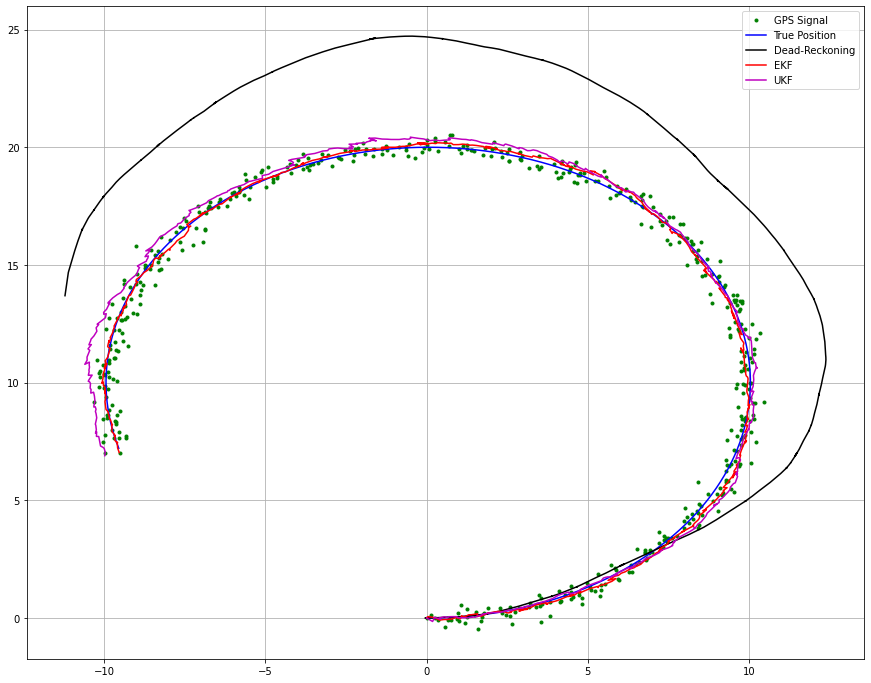

In [150]:
#One simulation
est_metrics = simulation()

- #### Filter comparison with the reality

Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-149-6a44694b05a7>:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (15,12))


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Robot simulation start!


<ipython-input-149-6a44694b05a7>:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,MSE_mean,MSE_std,RMSE_mean,RMSE_std,R^2_mean,R^2_std
Dead-Reckoning,13.107212,12.260009,3.112614,1.520685,0.717878,0.264247
EKF,0.017333,0.002891,0.130858,0.010438,0.999630,0.000063
UKF,0.078309,0.061248,0.262810,0.090823,0.998337,0.001283


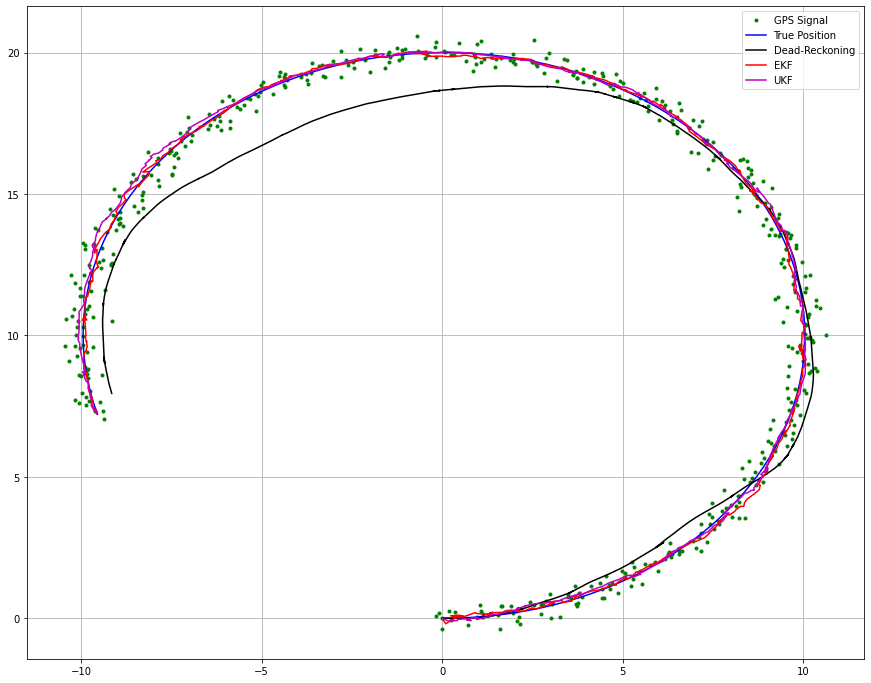

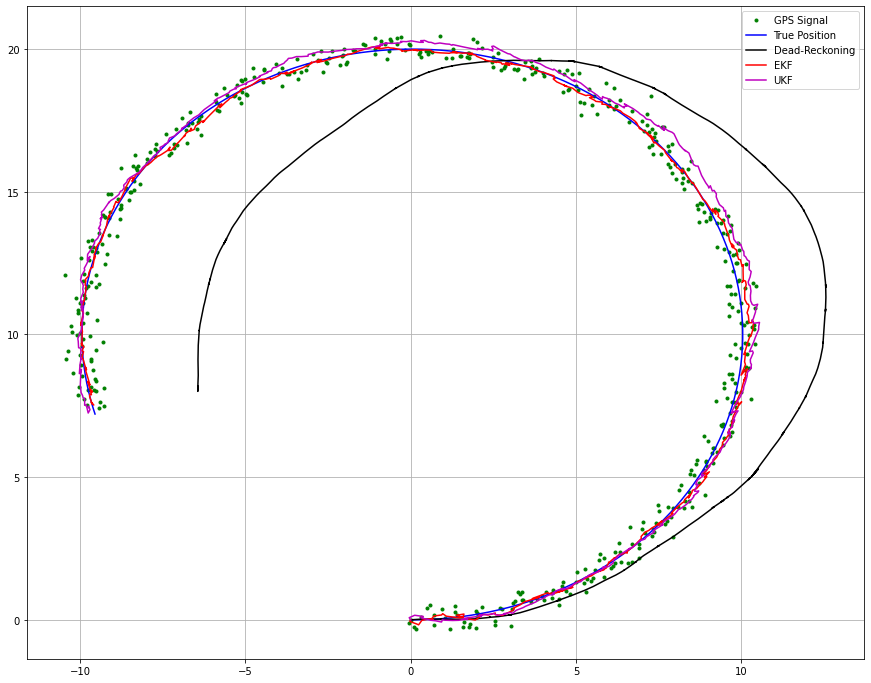

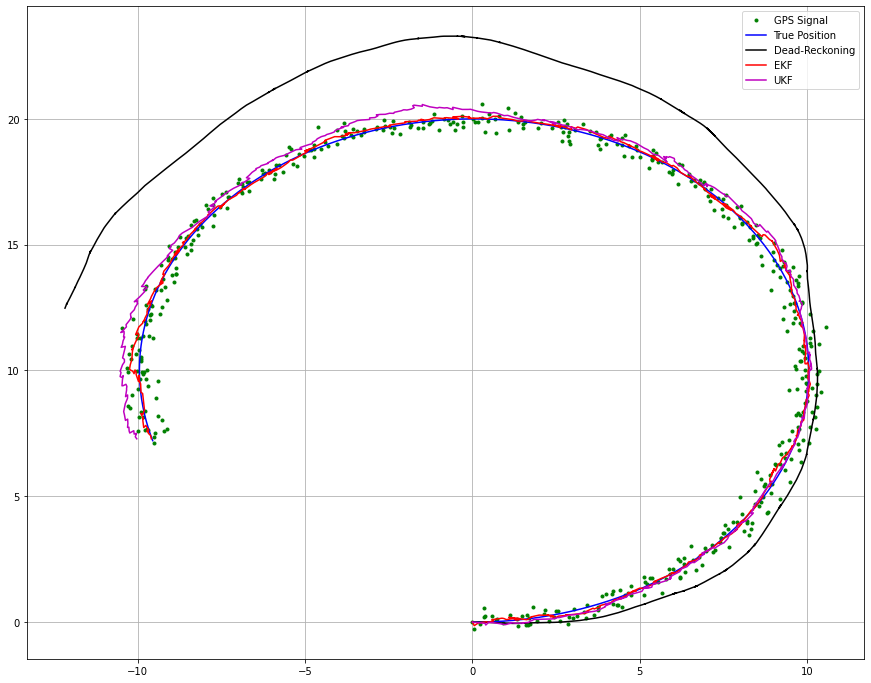

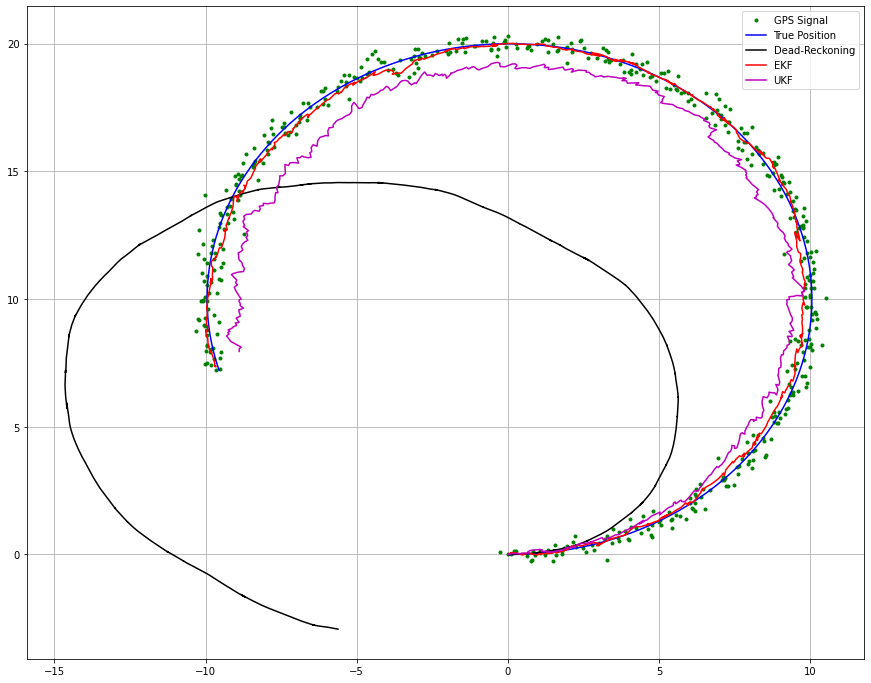

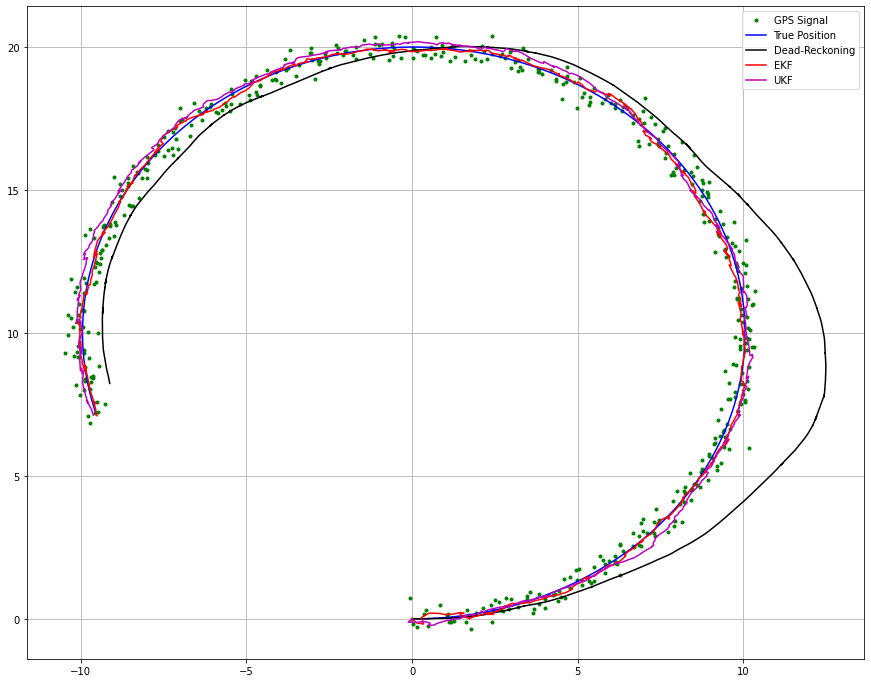

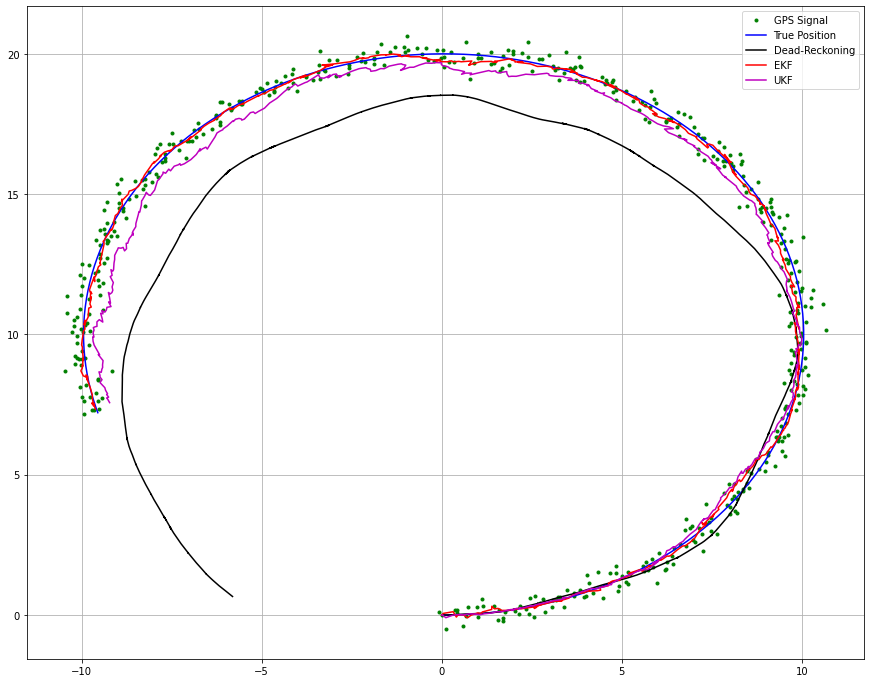

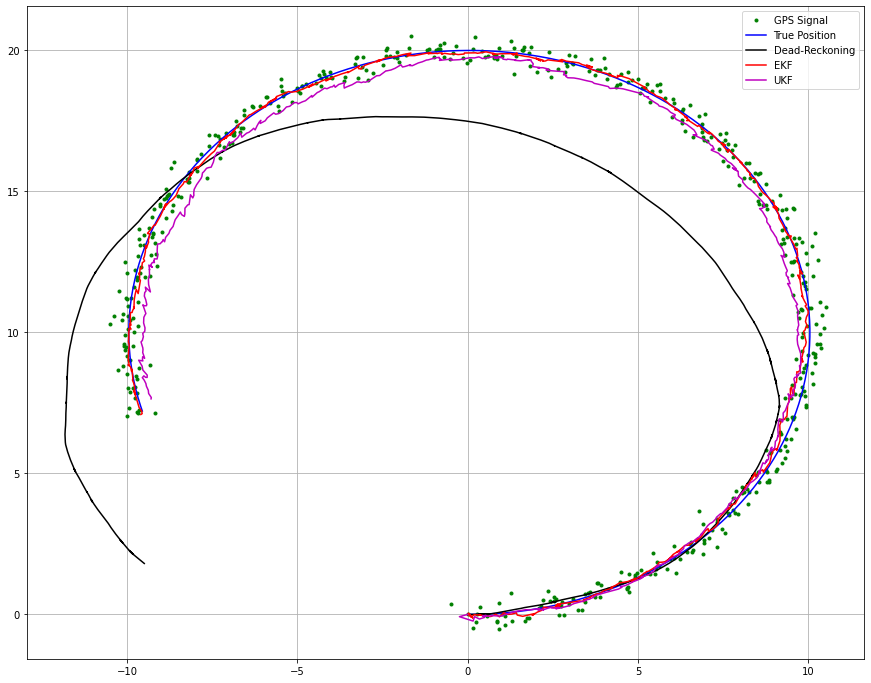

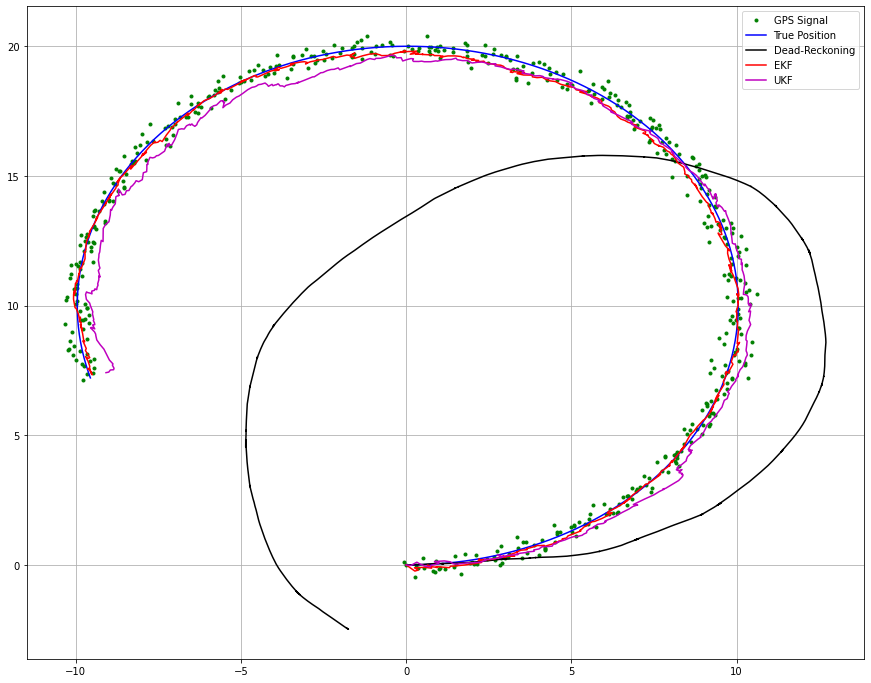

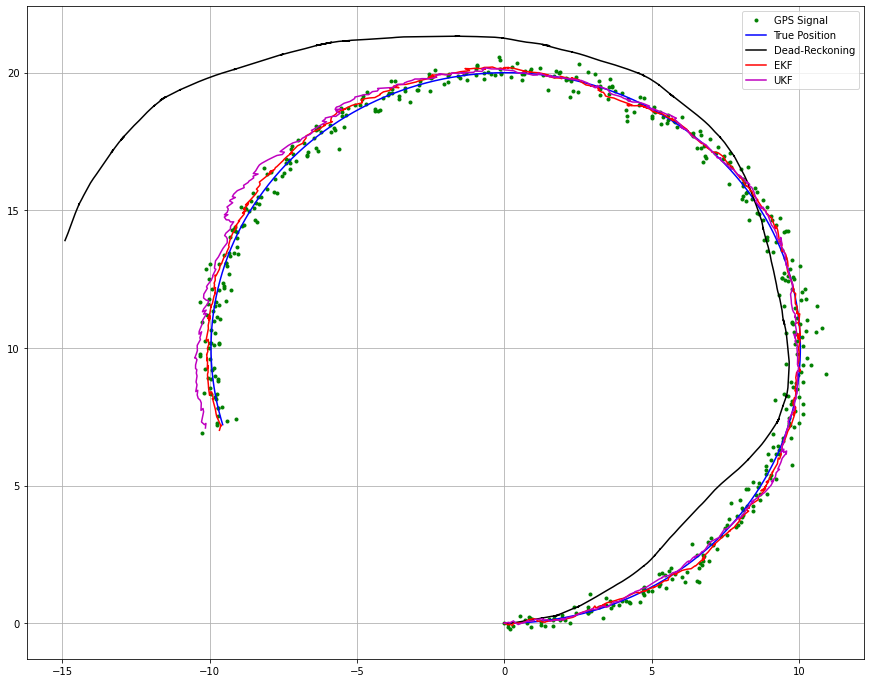

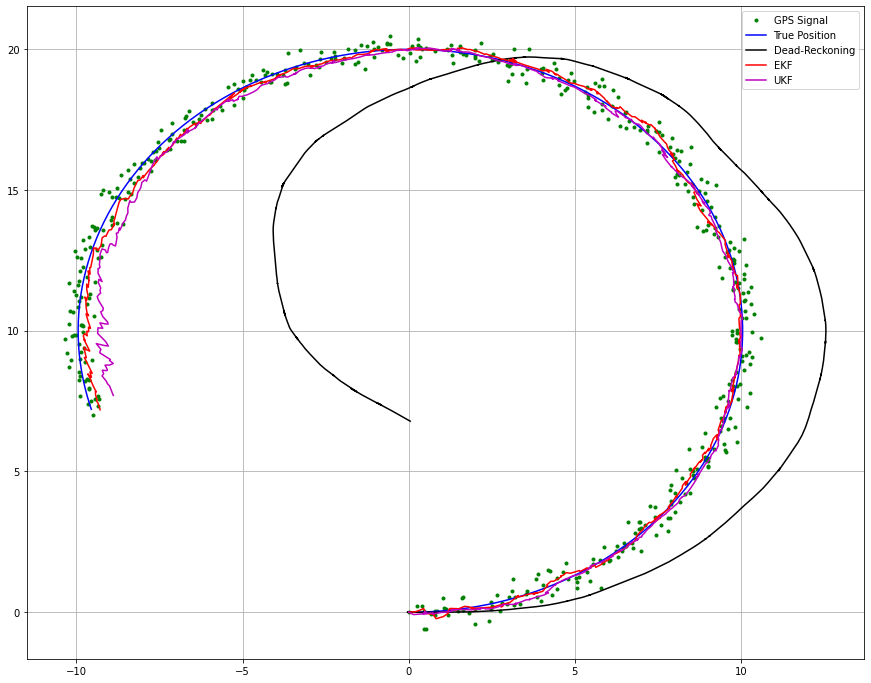

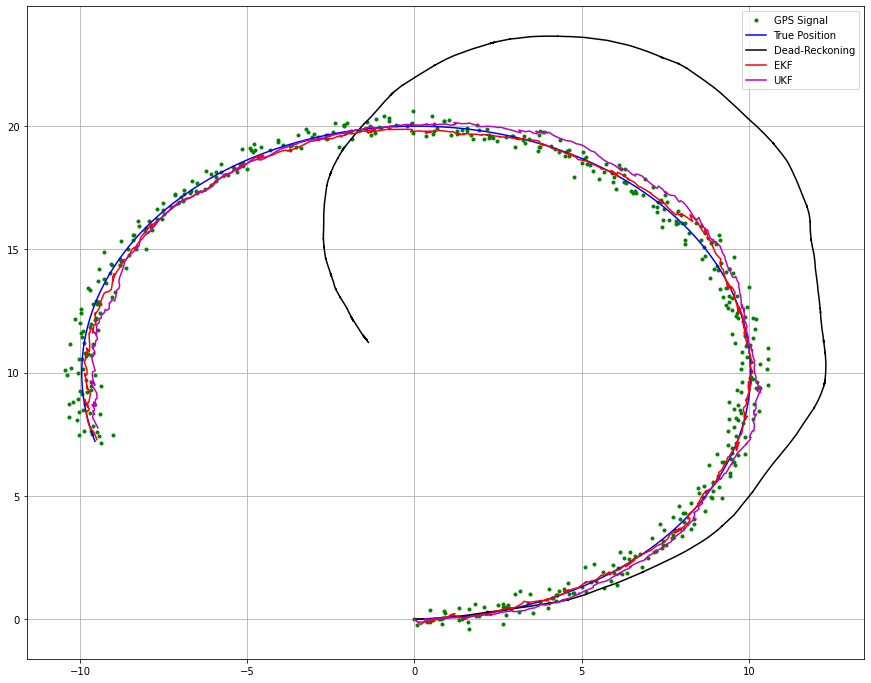

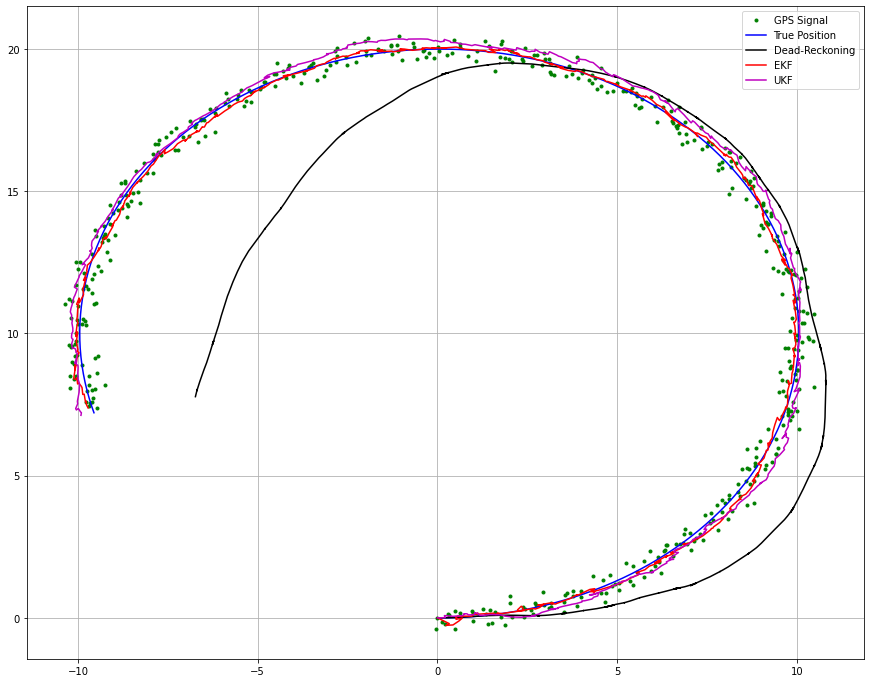

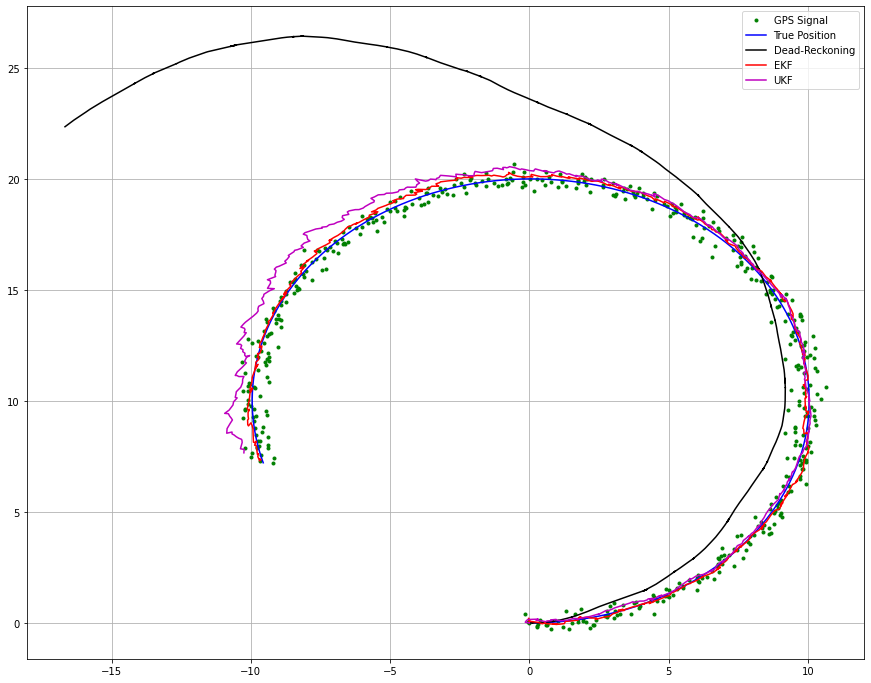

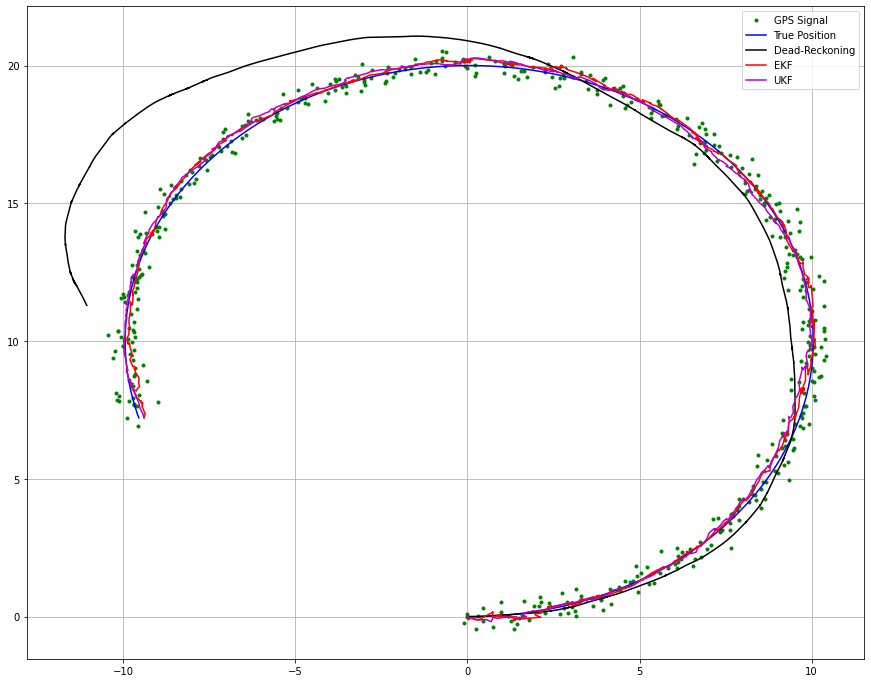

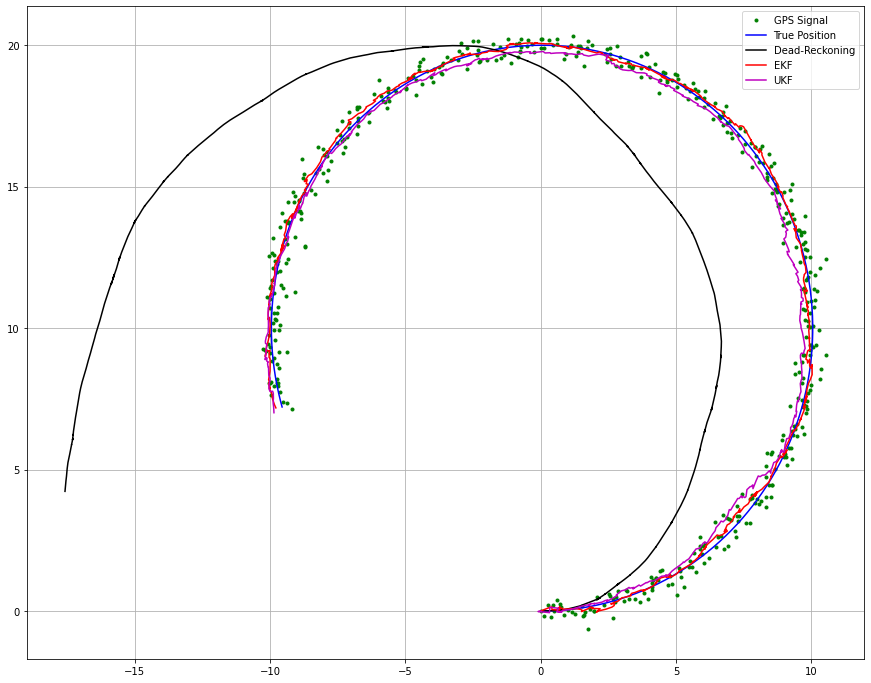

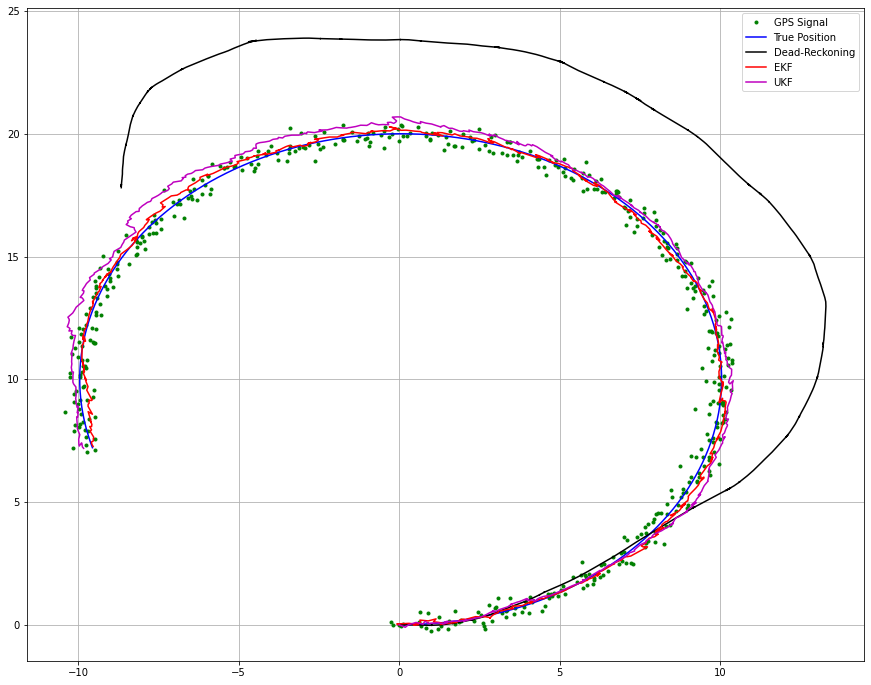

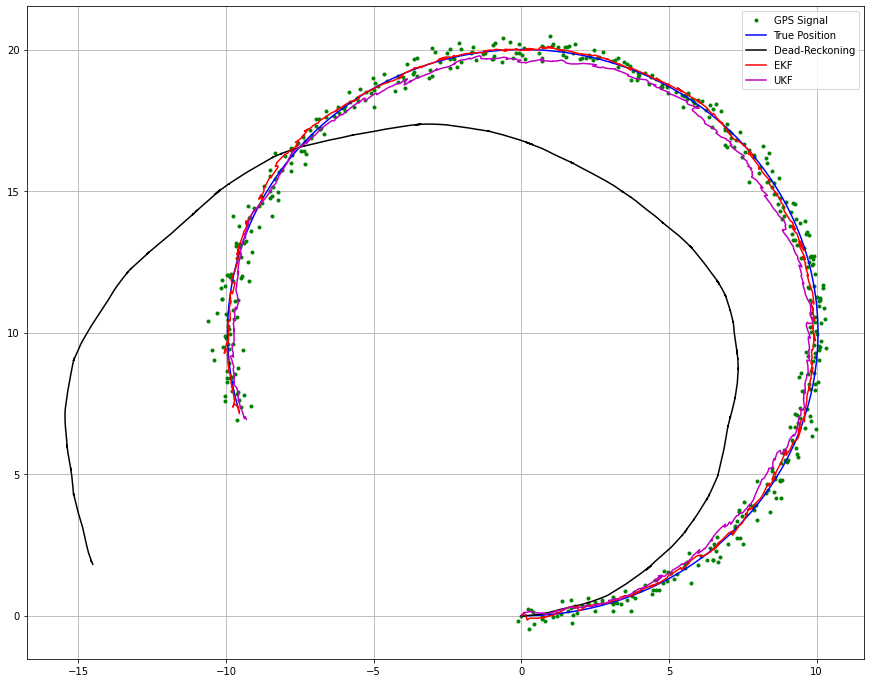

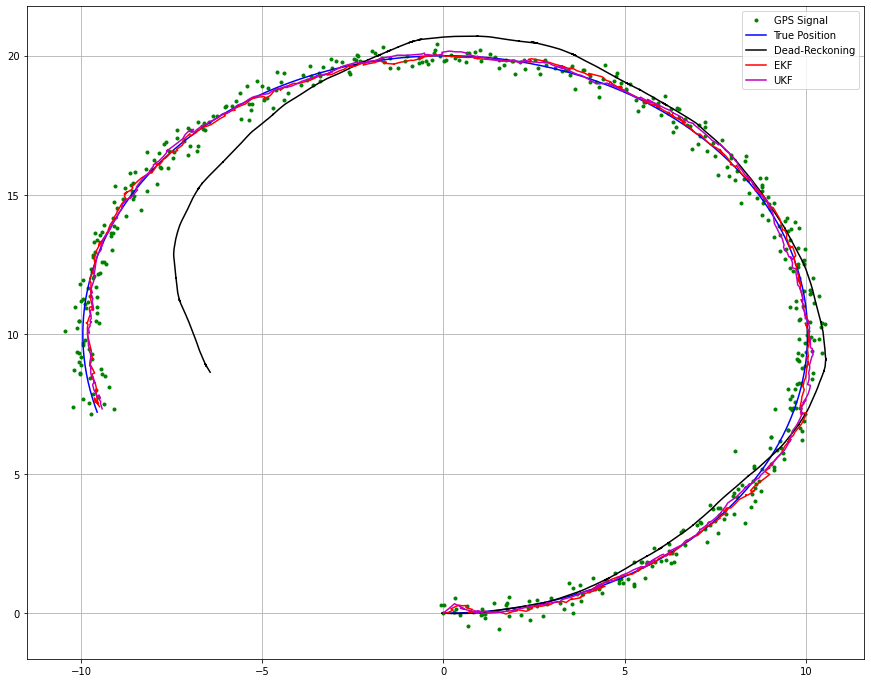

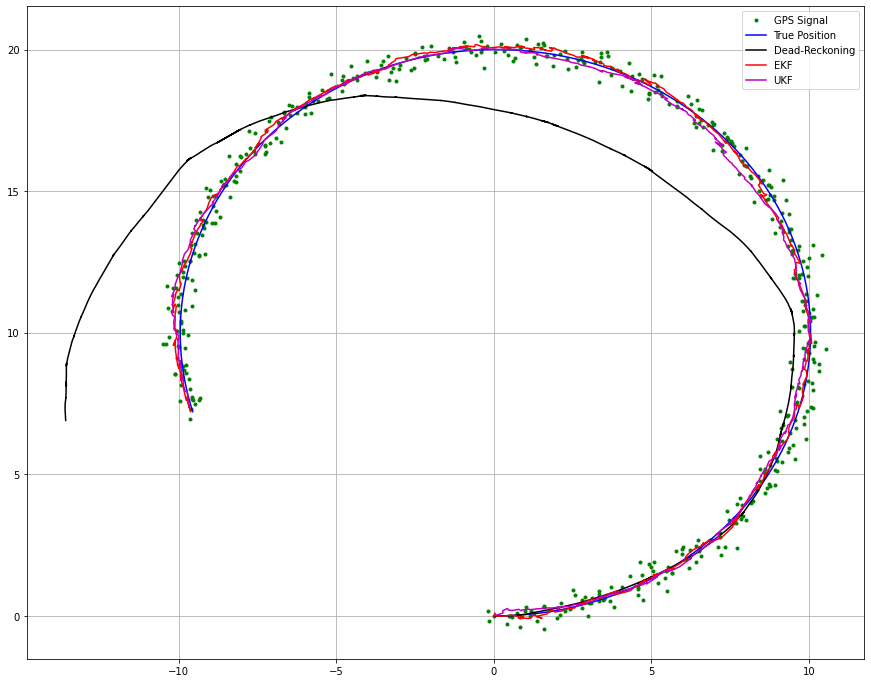

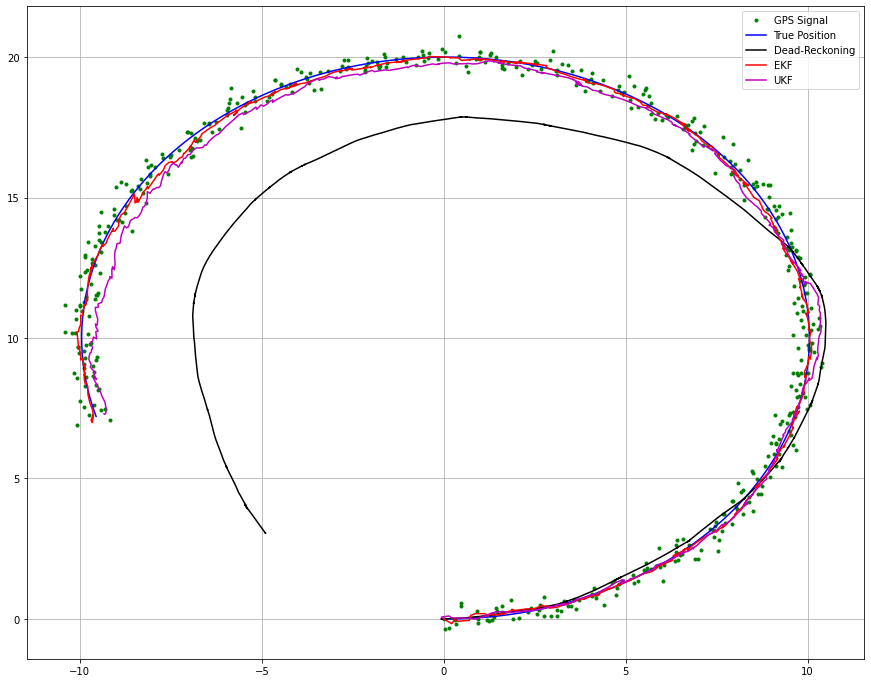

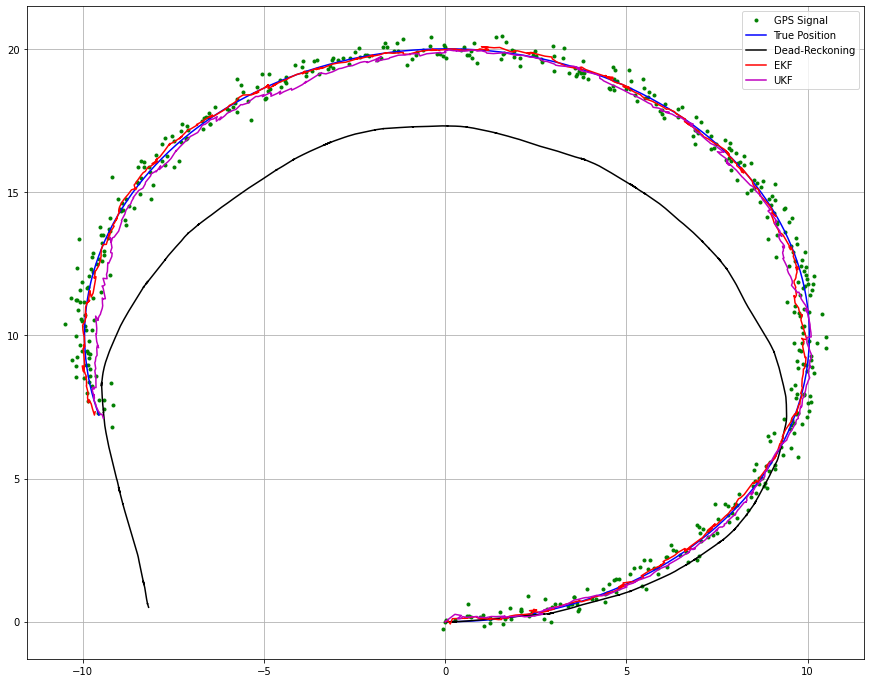

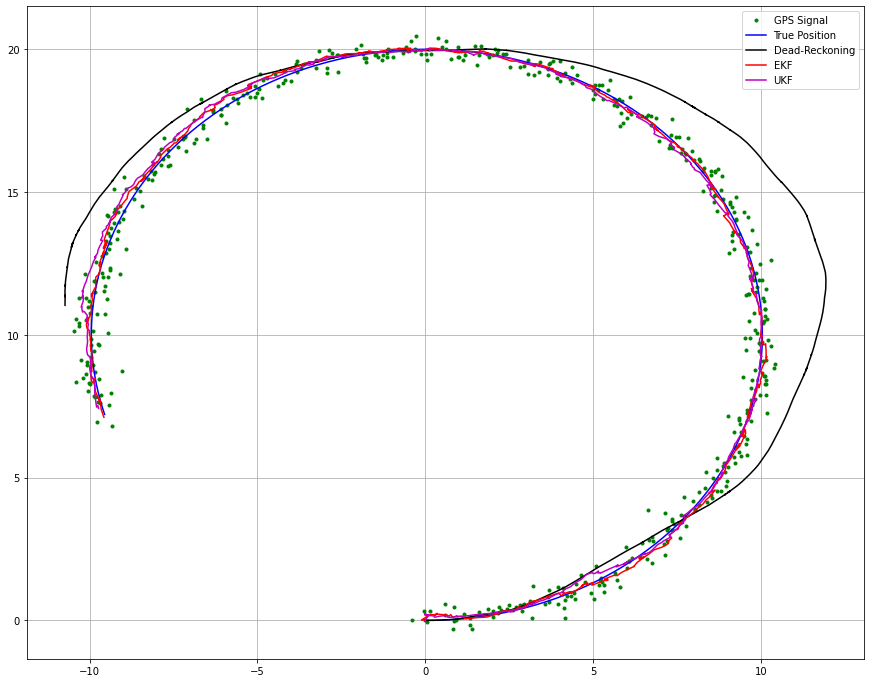

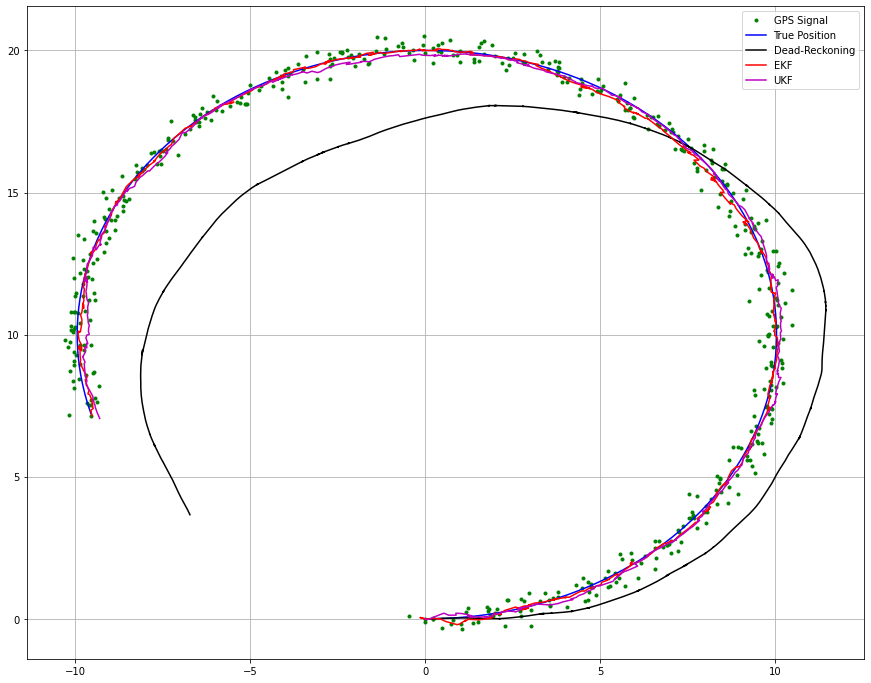

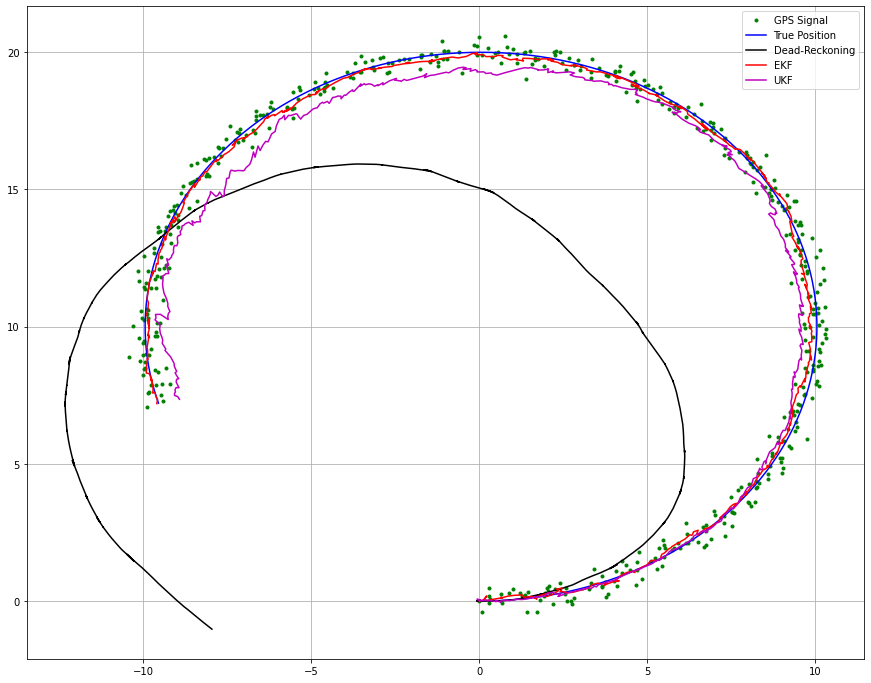

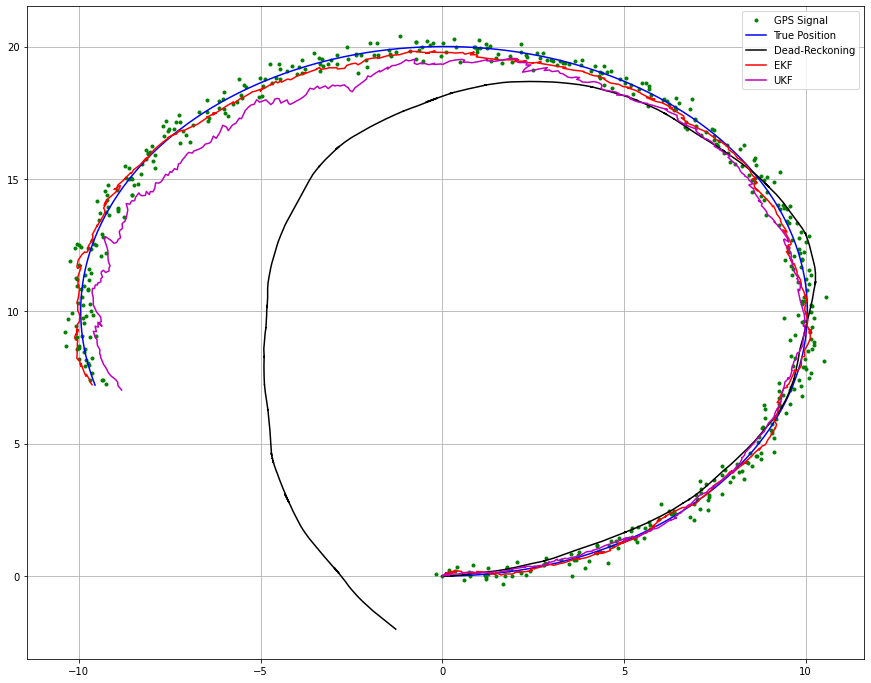

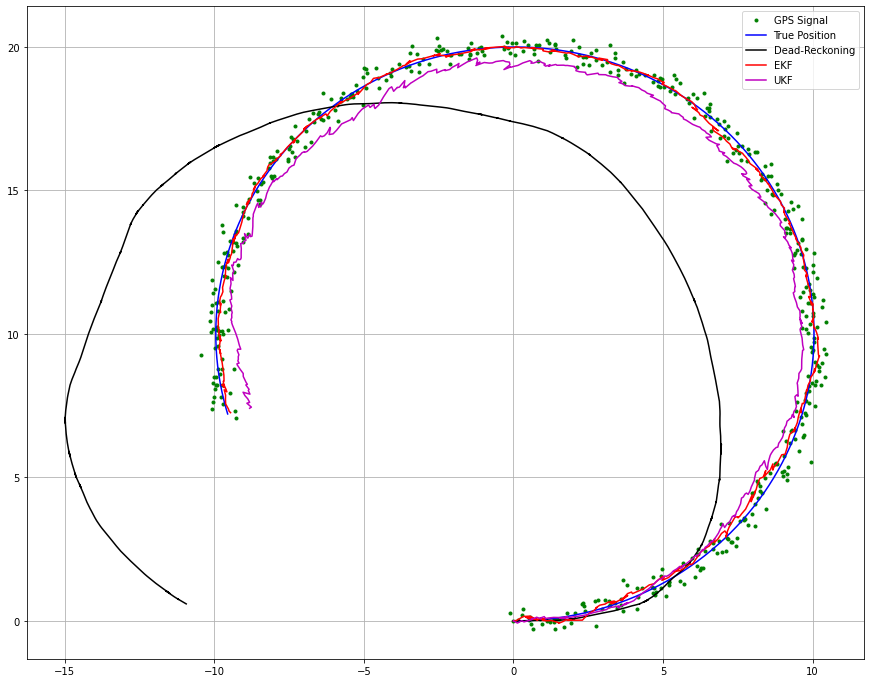

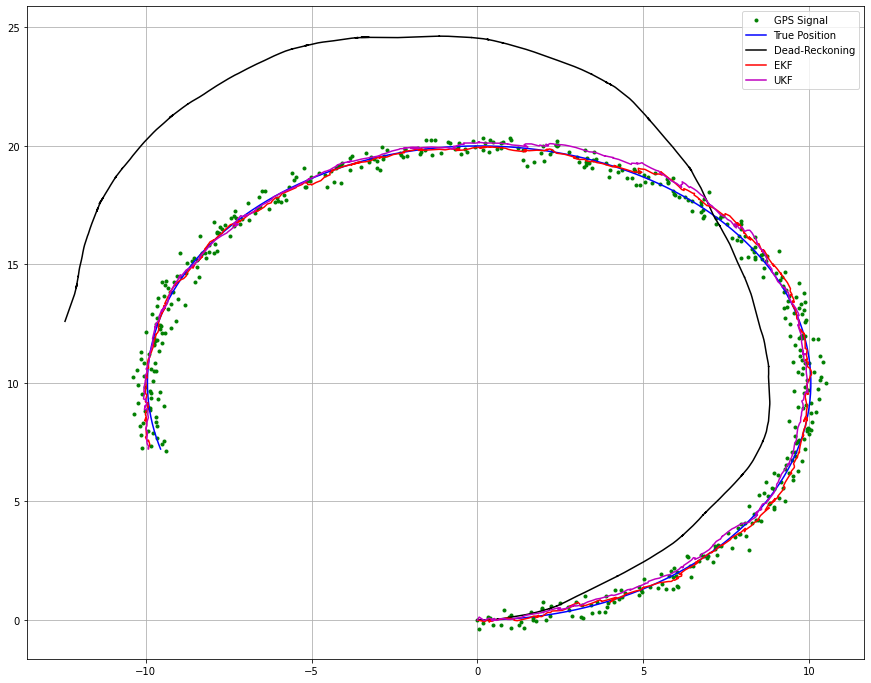

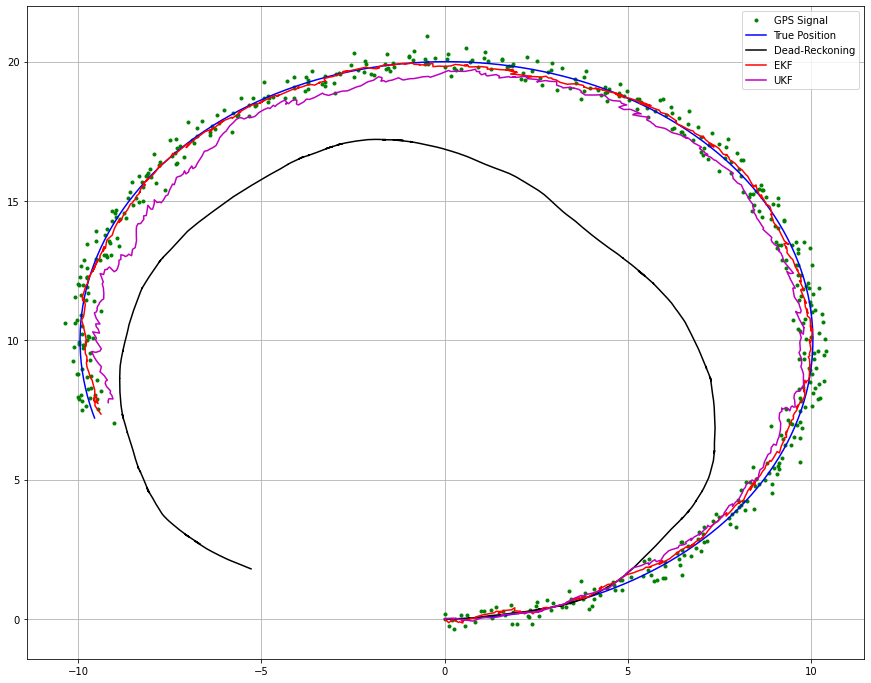

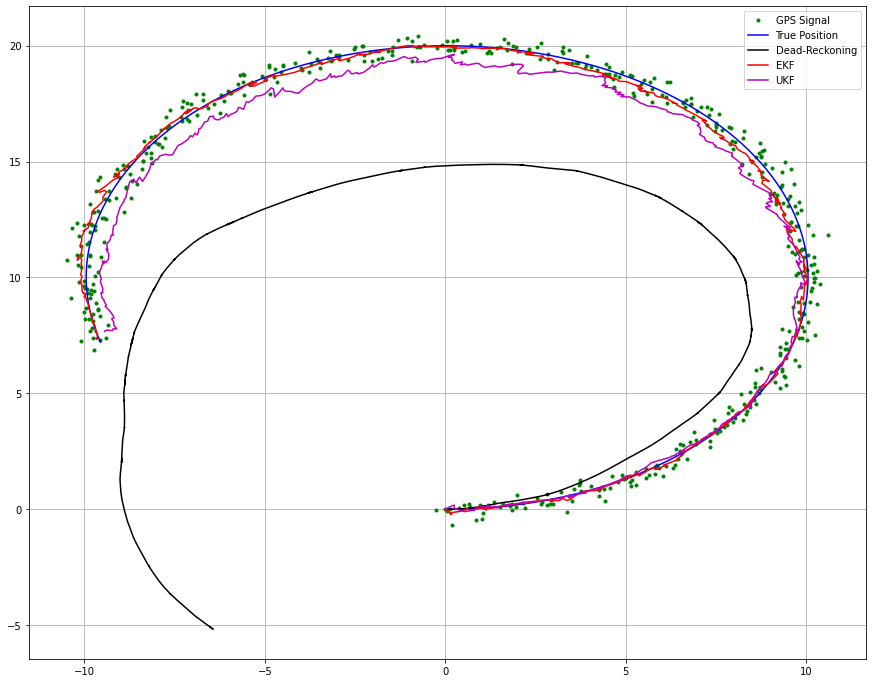

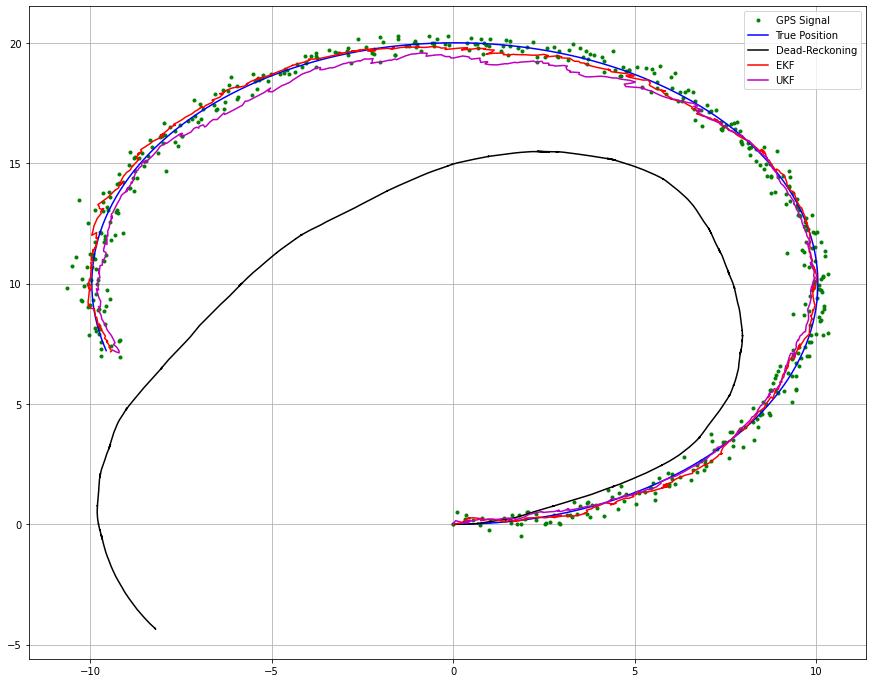

In [153]:
#Always a multiple of 5
numSimulations = 30

#First column = mean square error
#Second column = real mean square error
#Third column = r2
metrics_DR_sims = np.zeros((numSimulations,3))
metrics_EKF_sims = np.zeros((numSimulations,3))
metrics_UKF_sims = np.zeros((numSimulations,3))
metrics_PF_sims = np.zeros((numSimulations,3))


for i in range(numSimulations):
    # True position, dead-reckoning, ekf, ukf, particle filter
    metrics_DR,metrics_EKF,metrics_UKF,metrics_PF = simulation()
    metrics_DR_sims[i] = metrics_DR
    if ekf is True:
        metrics_EKF_sims[i] = metrics_EKF
    if ukf is True:
        metrics_UKF_sims[i] = metrics_UKF
    if pf is True:
        metrics_PF_sims[i] = metrics_PF

metrics_DR = []
metrics_UKF = []
metrics_EKF = []
metrics_PF = []

for i in range(3):
    metrics_DR.append(np.average(metrics_DR_sims[:,i])),
    metrics_DR.append(np.std(metrics_DR_sims[:,i]))
    if ekf is True:
        metrics_EKF.append(np.average(metrics_EKF_sims[:,i])),
        metrics_EKF.append(np.std(metrics_EKF_sims[:,i]))
    if ukf is True:
        metrics_UKF.append(np.average(metrics_UKF_sims[:,i])),
        metrics_UKF.append(np.std(metrics_UKF_sims[:,i]))
    if pf is True:
        metrics_PF.append(np.average(metrics_PF_sims[:,i])),
        metrics_PF.append(np.std(metrics_PF_sims[:,i]))
indexNames = ["Dead-Reckoning"]
finalData = [metrics_DR]

if ekf is True:
    indexNames.append("EKF")
    finalData.append(metrics_EKF)
if ukf is True:
    indexNames.append("UKF")
    finalData.append(metrics_UKF)
if pf is True:
    indexNames.append("Particle Filter")
    finalData.append(metrics_PF)


df_metrics = pd.DataFrame( data = finalData,
    
    columns=[
        "MSE_mean",
        "MSE_std",
        "RMSE_mean",
        "RMSE_std",
        "R^2_mean",
        "R^2_std"
    ],
    index= indexNames)

In [ ]:
df_metrics

## **5. Final Report**